# Diabetes prediction

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import graphviz


In [2]:
df = pd.read_csv('./data/diabetes_prediction_dataset.csv')

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [7]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}


In [8]:
print('Best score', grid_search.best_score_)

Best score 0.9563625


<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_15076\3804157326.py:12: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')


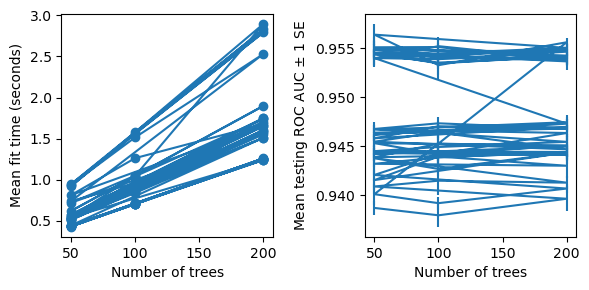

In [14]:
cv_rf_ex_results_df = pd.DataFrame(grid_search.cv_results_)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].plot(cv_rf_ex_results_df['param_classifier__n_estimators'],
            cv_rf_ex_results_df['mean_fit_time'],
            '-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[1].errorbar(cv_rf_ex_results_df['param_classifier__n_estimators'],
cv_rf_ex_results_df['mean_test_score'],
yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4))
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')
plt.tight_layout()

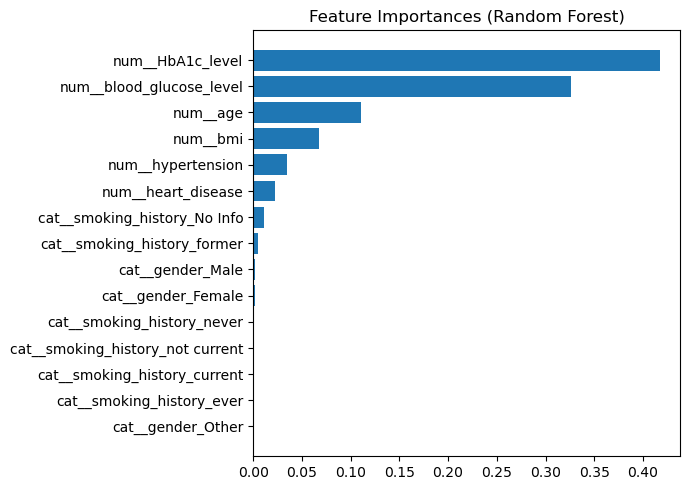

In [16]:
# Lấy model RandomForest
best_model = grid_search.best_estimator_
best_rf = best_model.named_steps['classifier']

# Lấy phần preprocessing trong pipeline (nếu có)
preprocessor = best_model.named_steps['preprocessor']

# Lấy tên các feature sau khi đã transform (one-hot, scale, v.v.)
feature_names = preprocessor.get_feature_names_out()

# Tạo DataFrame biểu diễn feature importances
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=True)

# Vẽ biểu đồ
plt.figure(figsize=(7, 5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

